In [1]:
from scipy.io.wavfile import write
from functools import reduce
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt

source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
dst    = '/home/sobolev/nevermind/Andrey/analysis/showroom'

In [14]:
def get_harm_stack(base_freq, duration, threshold=1500, sample_rate=44100):
    harmonics = [x * base_freq for x in np.arange(20) + 2 if x * base_freq < threshold]  # first 20 enouch
    freqs = [base_freq] + harmonics
    x = np.linspace(0, duration, int(sample_rate * duration))
    y = reduce(lambda x, y: x + y, [(1./(i+1)) * np.sin(base_freq * 2 * np.pi * x) for i, base_freq in enumerate(freqs)])
    return y / y.max()  # norm to -1 to 1

In [15]:
def get_cos_window(tone, win_duration, sample_rate=44100):
    x = np.linspace(0, np.pi/2, int(win_duration * sample_rate), dtype=np.float32)
    onset =  np.sin(x)
    middle = np.ones(len(tone) - 2 * len(x))
    offset = np.cos(x)
    return np.concatenate([onset, middle, offset])

In [38]:
f1, f2 = 660, 1320
s_rate = 44100

tones = []
for freq in [f1, f2]:
    tone = get_harm_stack(freq, 0.05, sample_rate=s_rate)
    tone = tone * get_cos_window(tone, 0.01, s_rate)  # onset / offset
    tone = tone * 1  # amplitude
    tones.append(tone)

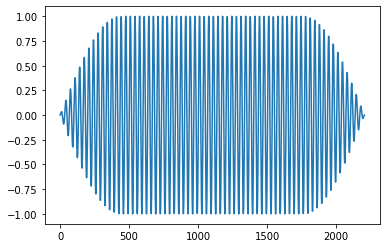

In [39]:
plt.plot(tones[1])

In [60]:
session = '009266_hippoSIT_2023-04-20_08-57-39'
animal = session.split('_')[0]
s_path = os.path.join(source, animal, session)
meta_file  = os.path.join(source, animal, session, 'meta.h5')
with h5py.File(meta_file, 'r') as f:
    events = np.array(f['processed']['sound_events'])
    
t1, t2 = 40, 85
events_f = events[(events[:, 0] > t1) & (events[:, 0] < t2)]

In [66]:
sig = np.zeros((t2 - t1)*s_rate)
for bgr_event in events_f[events_f[:, 1] == 1]:
    idx_l = int((bgr_event[0] - t1)*s_rate)
    idx_r = idx_l + len(tones[0])
    if idx_r < len(sig):
        sig[idx_l:idx_r] = tones[0]
for tgt_event in events_f[events_f[:, 1] == 2]:
    idx_l = int((tgt_event[0] - t1)*s_rate)
    idx_r = idx_l + len(tones[1])
    sig[idx_l:idx_r] = tones[1]

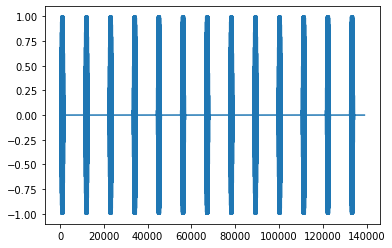

In [67]:
plt.plot(sig[11000:150000])

In [69]:
write(os.path.join(dst, "%s_%s_%s.wav" % (session, str(t1), str(t2))), s_rate, sig.astype(np.float32))

## Put together video and audio

In [74]:
sbox_path = '/home/sobolev/nevermind/Andrey/analysis/sandbox'

vidfile = os.path.join(sbox_path, 'manifolds.mp4')
audfile = os.path.join(sbox_path, 'audio.wav')
outfile = os.path.join(sbox_path, 'manifolds_combined.avi')
os.system('ffmpeg -y -i "' + vidfile + '" -i "' + audfile + '" -c:v copy -c:a aac "' + outfile + '"') 

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

0

## Sample audio wav

In [2]:
samplerate = 44100; fs = 100
t = np.linspace(0., 1., samplerate)
amplitude = np.iinfo(np.int16).max
data = amplitude * np.sin(2. * np.pi * fs * t)

In [35]:
#scaled = np.int16(data / np.max(np.abs(data)) * 32767)

array([ 0.00000000e+00,  4.66845433e+02,  9.33596096e+02, ...,
       -9.33596096e+02, -4.66845433e+02,  1.28734120e-10])

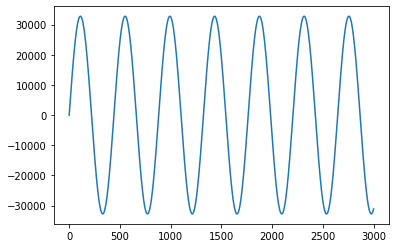

In [33]:
plt.plot(data[:3000])

In [5]:
write(os.path.join(dst, "example.wav"), samplerate, data.astype(np.int16))

## Read audio.mat and infer time of the first pulse

In [2]:
import scipy.io

src = '/home/sobolev/nevermind/AG_Pecka/data/raw/'
animal = '57'
session = '57_SIT_2023-12-18_14-07-34'

audio_file = os.path.join(src, animal, session, 'audio.mat5')

mat = scipy.io.loadmat(audio_file)

In [4]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'samplerate', 'wavedata'])